# Lab 3: Cooling models of the oceanic lithosphere

In this lab, we will calculate the bathymetry of the oceans predicted by two conductive cooling models of the oceanic lithosphere: the half-space model and the plate model. To assess model predictions, we'll use bathymetry data from [ETOPO1](https://doi.org/10.7289/V5C8276M) and age of the oceanic lithosphere data from [Müller et al. (2008)](https://doi.org/10.1029/2007GC001743).

Learning objectives:

* Expand on the theorical knowledge acquired in [Lecture 3](https://www.leouieda.com/envs398/slides/3-oceanic-lithosphere/).
* Apply the principles of isostatic equilibrium to estimate bathymetry from cooling models.
* Convert the theoretical knowledge into computations that can be used to model real data.

## General instructions

This is a [Jupyter notebook](https://jupyter.org/) running in [Jupyter Lab](https://jupyterlab.readthedocs.io/en/stable/). The notebook is a programming environment that mixes code (the parts with `[1]: ` or similar next to them) and formatted text/images/equations with [Markdown](https://www.markdownguide.org/basic-syntax) (like this part right here).

Quick start guide:

* **Edit** any cell (blocks of code or text) by double clicking on it.
* **Execute** a code or Markdown cell by typing `Shift + Enter` after selecting it.
* The current active cell is the one with a **blue bar next to it**.
* You can run cells **in any order** as long as the code sequence makes sense (it's best to go top-to-bottom, though).
* To copy any file to the current directory, drag and drop it to the file browser on the left side.
* Notebook files have the extension `.ipynb`.

## Import things

As before, the first thing to do is load the Python libraries that we'll be using. We'll group all our imports here at the top to make it easier to see what we're using.

In [15]:
# The base of the entire scientific Python stack
import numpy as np
# Scipy defines a bunch of scientific goodness on top of numpy
import scipy.integrate
import scipy.special
# For making plots and figures
import matplotlib.pyplot as plt
# To load and operate on data tables
import pandas as pd

## Load the data

The data that we will try to fit with our cooling models are in [CSV](https://en.wikipedia.org/wiki/Comma-separated_values) files in the `data` folder. We'll use `pandas` to load them below.

In [2]:
atlantic = pd.read_csv("../data/atlantic-bathymetry-age.csv")
atlantic

,longitude,latitude,age_myr,bathymetry_m
0,-24.75,-29.75,54.125000,-5094.5
1,-24.25,-29.75,50.125000,-4838.5
2,-23.75,-29.75,46.995003,-4732.0
3,-23.25,-29.75,45.165000,-4473.0
4,-22.75,-29.75,43.210000,-4477.0
...,...,...,...,...
2995,-2.25,-0.25,57.670000,-5074.0
2996,-1.75,-0.25,60.945000,-5029.0
2997,-1.25,-0.25,63.720000,-4984.0
2998,-0.75,-0.25,66.619995,-4964.0


In [3]:
pacific = pd.read_csv("../data/pacific-bathymetry-age.csv")
pacific

,longitude,latitude,age_myr,bathymetry_m
0,-144.650538,-49.655172,58.02,-4630.0
1,-143.951613,-49.655172,57.54,-4648.0
2,-143.252688,-49.655172,56.98,-4503.5
3,-142.553763,-49.655172,56.46,-4539.0
4,-141.854839,-49.655172,55.65,-4605.5
...,...,...,...,...
2692,-83.145161,-30.344828,29.50,-3886.0
2693,-82.446237,-30.344828,30.35,-3957.5
2694,-81.747312,-30.344828,31.18,-3981.0
2695,-81.048387,-30.344828,31.99,-4049.5


Both data sets contain the coordinates of the data points and their associated age (in million years) and bathymetry (in meters). We'll plot below the age versus bathymetry to see the relationship that our models will have to fit.

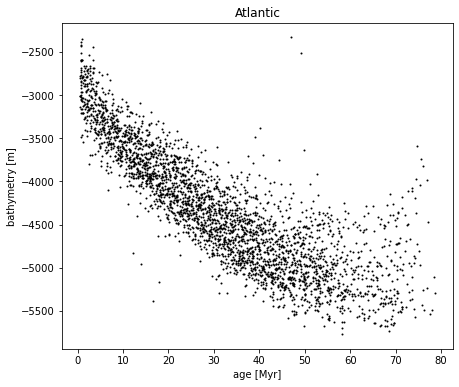

In [11]:
plt.figure(figsize=(7, 6))
plt.title("Atlantic")
plt.plot(atlantic.age_myr, atlantic.bathymetry_m, ".k", markersize=2)
plt.xlabel("age [Myr]")
plt.ylabel("bathymetry [m]")
plt.show()

----

### YOUR TURN

Make a similar plot for the Pacific dataset below.

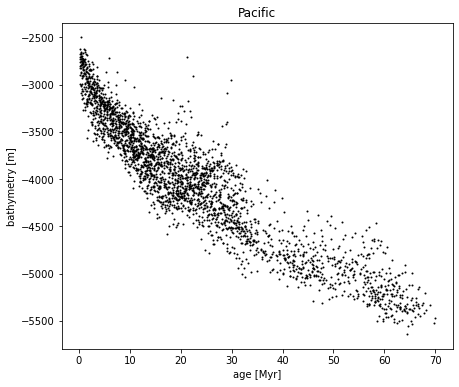

In [12]:
plt.figure(figsize=(7, 6))
plt.title("Pacific")
plt.plot(pacific.age_myr, pacific.bathymetry_m, ".k", markersize=2)
plt.xlabel("age [Myr]")
plt.ylabel("bathymetry [m]")
plt.show()


----

## Predicting bathymetry from half-space cooling



### Calculating error functions

The `scipy.special` module has several useful mathematical functions, like [Bessel functions](https://en.wikipedia.org/wiki/Bessel_function) and the [error function](https://en.wikipedia.org/wiki/Error_function). To calculate the complementary error function $\text{erfc}$, we can use `scipy.special.erfc`. As an example, here is the $\text{erfc}$ function calculated between $[-5, 5]$.

In [22]:
x = np.linspace(-5, 5, 100)
y = scipy.special.erfc(x)

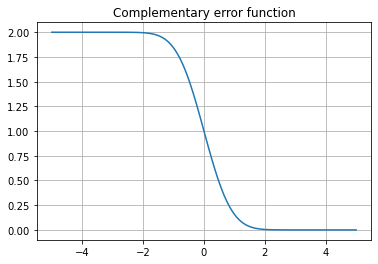

In [25]:
plt.figure()
plt.title("Complementary error function")
plt.plot(x, y)
plt.grid()
plt.show()

### Solving integrals in Python

Scipy also has the `scipy.integrate` module which offers numerical integration functions. To solve an integral over a single variable, we'll use the `scipy.integrate.quad` function. This function takes as arguments the integration limits and a Python function that implements the mathematical function we wish to integrate. 

For example, to solve the following integral:

$$ \int\limits_0^{3} x^2 dx = y $$

If you remember your basic calculus, you should be able to figure out that this integral should be equal to 9. 

To solve it with Python, we have to first define a function $f(x) = x^2$ that we wish to integrate.

In [26]:
def integrand(x):
    "Function that will be integrated"
    result = x**2
    return result

Now we can integrate it using `scipy.integrate.quad` like so:

In [29]:
integral, accuracy = scipy.integrate.quad(integrand, 0, 3)
print(integral, accuracy)

9.000000000000002 9.992007221626411e-14


The `quad` function returns the integral and the estimated accuracy of the solution.

### Solving the bathymetry equation

Now we can put together the parts we saw above to calculate the bathymetry predictions for the half-space model:

$$ w(t) = w_r + \dfrac{\rho_a \alpha_V (T_a - T_0)}{\rho_a - \rho_w} \int\limits_0^L \text{erfc}\left(\dfrac{z}{2\sqrt{\alpha t}}\right)dz $$

The input parameters will be $w_r$, $\rho_w$, $\rho_a$, $\alpha_V$, $\alpha$, $\T_a$

In [ ]:
def bathymetry_halfspace(age, ridge_depth, density_mantle, density_water, )